In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
import dlib
import glob
import os
import scipy.io as sio 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline

In [15]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1408, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 7), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(7))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [16]:
# Global parameters and operations
BATCH_SIZE = 128

# define placeholders for input variables
x_holder = tf.placeholder(tf.float32, (None, 30, 100, 1))
y_holder = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y_holder, 7)

# define the dlib detector and predictor
predictor_path = "shape_predictor_68_face_landmarks.dat/data"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

logits = LeNet(x_holder)

# define the model evaluate operation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# define the predict operation
predict_operation = tf.argmax(logits, 1)

In [17]:
def pre_process(img, img_width=640, img_height=480, out_width=50, out_height=30):
    """Input a raw image, process to a certain format to throw into CNN."""
    """Return combined, equalized eyes with size (30, 100, 1)."""
    # gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # if the input image is not (640x480), resize to this shape.
    if gray.shape != (img_height, img_width):
        gray = cv2.resize(gray,(img_width, img_height),interpolation=cv2.INTER_CUBIC)
    # Do a Histogram Equalization 
    equ = cv2.equalizeHist(gray)
    # extract eyes by dlib and concatenate left and right eye images.
    eyes_img = extract_eyes_by_dlib(equ, pad_scale=0.4, resize_width=out_width, resize_height=out_height, combine=True)
    print(eyes_img.shape)
    # eyes_img.shape = (30, 100, 1)
    return eyes_img.reshape(out_height, out_width*2, 1)


def load_eye_cinmera():
    """Load in Eye_Cinmera dataset, return X,y,Mat"""
    X = []
    y = []
    Mat = []
    for i in range(7):
        faces_folder_path = "./data/Eye_chimeraToPublish/" + str(i)
        for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
            f_name = os.path.basename(f)
            f_basename = f_name.split(".", 1)[0]
            # matrix file has the same name with the image file
            mat_name = f_basename + ".mat"
            mat_path = os.path.join(faces_folder_path, mat_name)
            img = io.imread(f)
            X.append(img)
            y.append(i)
            Mat.append(sio.loadmat(mat_path)['eyePoints'])
    return X, y, Mat
X, y, Mat = load_eye_cinmera()


def extract_eye_by_mat(X, Mat, pad_scale=0.4, resize_width=50, resize_height=30):
    """given image and eye location datasets, return two eye images dataset."""
    X_left = []
    X_right = []
    for (img, mat) in zip(X, Mat):
        # the four egdes of left and right eyes
        left_left = mat[0][0]
        left_right = mat[1][0]
        left_top = mat[2][1]
        left_bottom = mat[3][1]
        right_left = mat[5][0]
        right_right = mat[6][0]
        right_top = mat[7][1]
        right_bottom = mat[8][1]
        # cut eyes images from the original one
        
        left_pad_width = int((left_right - left_left) * pad_scale)
        left_pad_height = int((left_bottom - left_top) * pad_scale)
        
        right_pad_width = int((right_right - right_left) * pad_scale)
        right_pad_height = int((right_bottom - right_top) * pad_scale)
        
        left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width, :]
        right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width, :]
        
        # reshape eye images to 50x42
        X_left.append(cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        X_right.append(cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        
    return np.array(X_left), np.array(X_right)


def comb_hist_eye_cinmera(X_left, X_right):
    "Combine the left and right eyes image and do a histgram equlization. "
    X_combine = np.concatenate((X_left, X_right), axis=2)
    X_combine_equ = np.empty(30*100*1135).reshape(1135, 30, 100, 1)
    for i in range(1135):
        equ = hist_equ(X_combine[i])
        X_combine_equ[i] = equ
    return X_combine_equ


def extract_eyes_by_dlib(img, pad_scale=0.4, resize_width=50, resize_height=30, combine=False):
    # get facial landmark matrix by dlib
    mat = get_landmarks(img)
    
    left_left = mat[36,0]
    left_right = mat[39,0]
    left_top = min(mat[37,1], mat[38,1])
    left_bottom = max(mat[40,1], mat[41,1])
    right_left = mat[42,0]
    right_right = mat[45,0]
    right_top = min(mat[43,1], mat[44,1])
    right_bottom = max(mat[46,1], mat[47,1])
    # left pad
    left_pad_width = int((left_right - left_left) * pad_scale)
    left_pad_height = int((left_bottom - left_top) * pad_scale)
    # right pad
    right_pad_width = int((right_right - right_left) * pad_scale)
    right_pad_height = int((right_bottom - right_top) * pad_scale)
    # left and right eye plus pads
    left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width]
    right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width]
    # resize
    left_eye = cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    right_eye = cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    if combine:
        return np.concatenate((left_eye, right_eye), axis=1)    
    return left_eye, right_eye


def get_landmarks(img):
    """Single face landmark detector. return an nparray."""
    rects = detector(img, 1)
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])


def hist_equ(img):
    """Do a histogram equlization to a RGB image. return image shape:(:,:,1)"""
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray_img)
    return equ.reshape(equ.shape[0], equ.shape[1], 1)


def shuffle_and_split(X, y, valid_ratio=0.2):
    # Shuffle X and y
    X, y = shuffle(X, y)
    print(X.shape)
    # Split out test set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_ratio, random_state=42)
    print("X_train shape: ", X_train.shape)
    print("X_valid shape: ", X_valid.shape)
    print("y_train shape: ", len(y_train))
    print("y_valid shape: ", len(y_valid))
    # chang data type to floate32
    # X_train = X_train.astype('float32')
    # X_test = X_test.astype('float32')
    # plt.figure(2, figsize=(16,20))
    # for i in range(0, 9):
    #     plt.subplot(9, 1, i+1)
    #     plt.tight_layout()
    #     plt.imshow(X[i].squeeze())
    #     plt.title(str(y[i]))
    return X_train, X_valid, y_train, y_valid


def evaluate(X_data, y_data):
    """Evaluate the trained model on the input dataset, return the accuracy."""
    num_examples = len(X_data)
    total_accuracy = 0
    # tf.get_default_session(): Returns the default session for the current thread.
    # function evaluate() is called right after the training session.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # accuracy for this particular batch
        accuracy = sess.run(accuracy_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def predict(X_data):
    """Predict the input with the trained model, return the result as an integer (0-6)"""
    num_examples = len(X_data)
    sess = tf.get_default_session()    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        prediction = sess.run(predict_operation, feed_dict={x_holder: batch_x})
    return prediction

In [18]:
rate = 0.001
EPOCHS = 100
saver_path = "./trained_models/model.ckpt"

# define a tf model Saver object
saver = tf.train.Saver()

In [6]:
X, y, Mat = load_eye_cinmera()
X_left, X_right = extract_eye_by_mat(X, Mat)
X_combine_equ = comb_hist_eye_cinmera(X_left, X_right)

In [7]:
X_train, X_valid, y_train, y_valid = shuffle_and_split(X_combine_equ, y)

(1135, 30, 100, 1)
X_train shape:  (908, 30, 100, 1)
X_valid shape:  (227, 30, 100, 1)
y_train shape:  908
y_valid shape:  227


In [19]:
# logits = LeNet(x_holder)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
X_train_input = X_train
X_valid_input = X_valid
y_train_input = y_train
y_valid_input = y_valid

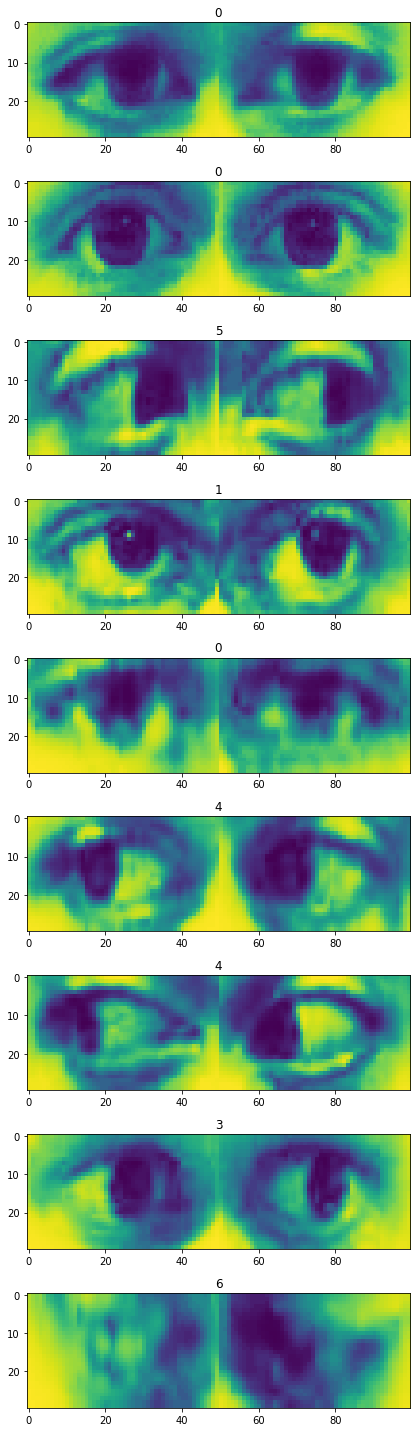

In [21]:
plt.figure(1, figsize=(16,20))
for i in range(0, 9):
    plt.subplot(9, 1, i+1)
    plt.tight_layout()
    plt.imshow(X_train_input[i].squeeze())
    plt.title(str(y_train_input[i]))

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_input)

    print("Training...")
    print()
    for i in range(EPOCHS):
        # change different X_train input
        X_train_input, y_train_input = shuffle(X_train_input, y_train_input)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_input[offset:end], y_train_input[offset:end]
            sess.run(training_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        # change different X_valid input    
        validation_accuracy = evaluate(X_valid_input, y_valid_input)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, saver_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.352

EPOCH 2 ...
Validation Accuracy = 0.696

EPOCH 3 ...
Validation Accuracy = 0.740

EPOCH 4 ...
Validation Accuracy = 0.727

EPOCH 5 ...
Validation Accuracy = 0.819

EPOCH 6 ...
Validation Accuracy = 0.824

EPOCH 7 ...
Validation Accuracy = 0.819

EPOCH 8 ...
Validation Accuracy = 0.859

EPOCH 9 ...
Validation Accuracy = 0.859

EPOCH 10 ...
Validation Accuracy = 0.859

EPOCH 11 ...
Validation Accuracy = 0.833

EPOCH 12 ...
Validation Accuracy = 0.863

EPOCH 13 ...
Validation Accuracy = 0.846

EPOCH 14 ...
Validation Accuracy = 0.850

EPOCH 15 ...
Validation Accuracy = 0.863

EPOCH 16 ...
Validation Accuracy = 0.872

EPOCH 17 ...
Validation Accuracy = 0.863

EPOCH 18 ...
Validation Accuracy = 0.863

EPOCH 19 ...
Validation Accuracy = 0.868

EPOCH 20 ...
Validation Accuracy = 0.863

EPOCH 21 ...
Validation Accuracy = 0.877

EPOCH 22 ...
Validation Accuracy = 0.859

EPOCH 23 ...
Validation Accuracy = 0.868

EPOCH 24 ...
Validation Accura